In [1]:
import numpy as np
import SimPEG 
import discretize
import properties
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class ExponentialSinusoidSimulation(SimPEG.Simulation.LinearSimulation):
    """
    This is the simulation class for the linear problem consisting of 
    exponentially decaying sinusoids
    """
    n_kernels = properties.Integer(
        "number of kernels defining the linear problem",
        default = 20
    )
    
    p = properties.Float(
        "rate of exponential decay of the kernel",
        default=-0.25
    )
    
    q = properties.Float(
        "rate of oscillation of the kernel",
        default = 0.25
    )

    def __init__(self, **kwargs):
        super(ExponentialSinusoidSimulation, self).__init__(**kwargs)
        
    @property
    def _jk(self):
        return np.linspace(1., 60., self.n_kernels)
    
    def _g(self, k):
        return (
            np.exp(self.p*self._jk[k]*self.mesh.vectorCCx) *
            np.cos(np.pi*self.q*self._jk[k]*self.mesh.vectorCCx)
        )

    @property
    def G(self):
        if getattr(self, '_G', None) is None: 
            G = np.empty((self.n_kernels, self.mesh.nC))

            for i in range(self.n_kernels):
                G[i, :] = self._g(i)
            
            self._G = G
        return self._G
        

In [3]:
mesh = discretize.TensorMesh([100])

In [5]:
# this is the simulation object, it has fields, dpred, mappings, a survey, ... 
sim = ExponentialSinusoidSimulation(
    mesh=mesh, 
    model_map=SimPEG.Maps.IdentityMap(mesh),
#     survey=SimPEG.NewSurvey.LinearSurvey()
)

In [7]:
sim_options = sim.serialize()
sim_options

{u'__class__': 'ExponentialSinusoidSimulation',
 'mesh': {u'__class__': 'TensorMesh',
  '_n': [100],
  'h': [[0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    0.01,
    

In [14]:
type(ExponentialSinusoidSimulation)

properties.base.base.PropertyMetaclass

In [17]:
from scipy.sparse import linalg


In [19]:
isinstance(sim.solver, linalg)

TypeError: isinstance() arg 2 must be a class, type, or tuple of classes and types

In [11]:
# create a model 
mtrue = np.zeros(mesh.nC)
mtrue[mesh.vectorCCx > 0.3] = 1.
mtrue[mesh.vectorCCx > 0.45] = -0.5
mtrue[mesh.vectorCCx > 0.6] = 0

In [9]:
# dpred is a vector
dpred = sim.dpred(mtrue)
print(dpred)

[  7.04018834e+00   4.14041969e+00  -9.93782975e-01  -4.46393702e+00
  -3.66021155e+00  -5.42051412e-01   1.58193136e+00   1.60537971e+00
   5.73664455e-01  -2.44612295e-01  -4.48122888e-01  -2.84138871e-01
  -7.46161437e-02   4.26646164e-02   7.27612633e-02   5.90210173e-02
   3.22579286e-02   6.71960934e-03  -1.12292528e-02  -1.84905476e-02]


In [10]:
# make_synthetic_data returns a data object
data = sim.make_synthetic_data(m=mtrue, standard_deviation=0.01)

In [14]:
# the new data misfit takes a data object and a simulation
dmis = SimPEG.NewDataMisfit.l2_DataMisfit(data=data, simulation=sim)

In [15]:
# set up the inversion - nothing new here
reg = SimPEG.Regularization.Tikhonov(mesh, alpha_s=1., alpha_x=1.)
opt = SimPEG.Optimization.InexactGaussNewton(maxIter=60)
invProb = SimPEG.InvProblem.BaseInvProblem(dmis, reg, opt)
directives = [
    SimPEG.Directives.BetaEstimate_ByEig(beta0_ratio=1e-2),
    SimPEG.Directives.TargetMisfit()
]
inv = SimPEG.Inversion.BaseInversion(invProb, directiveList=directives)
m0 = np.zeros_like(mtrue)

In [16]:
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same solver and solver_opts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.62e+01  1.00e+05  0.00e+00  1.00e+05    1.26e+06      0              
   1  4.62e+01  4.68e+04  3.53e-01  4.69e+04    8.21e+04      0              
   2  4.62e+01  3.21e+04  1.34e+00  3.21e+04    6.21e+04      0              
   3  4.62e+01  1.87e+04  4.95e+00  1.90e+04    4.82e+04      0   Skip BFGS  
   4  4.62e+01  1.23e+04  4.93e+00  1.25e+04    6.96e+04      0              
   5  4.62e+01  8.62e+03  7.92e+00  8.99e+03    3.84e+04      0              
   6  4.62e+01  4.13e+03  1.30e+01  4.73e+03    4.02e+04      0  

(-2, 2)

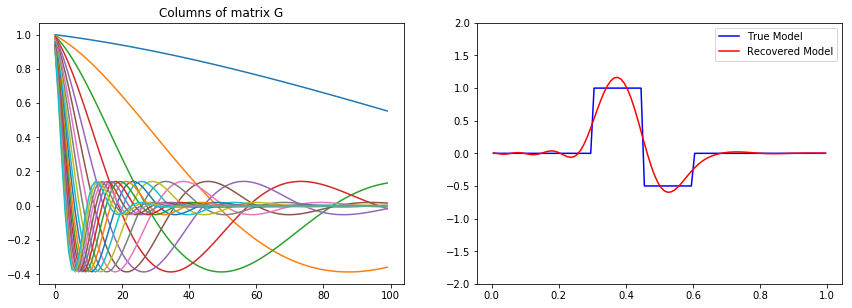

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12*1.2, 4*1.2))
for i in range(sim.G.shape[0]):
    axes[0].plot(sim.G[i, :])
axes[0].set_title('Columns of matrix G')

axes[1].plot(mesh.vectorCCx, mtrue, 'b-')
axes[1].plot(mesh.vectorCCx, mrec, 'r-')
axes[1].legend(('True Model', 'Recovered Model'))
axes[1].set_ylim([-2, 2])
